In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
from torchvision import transforms

import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf

In [2]:
def print_pattern(temp):
    data = {
            'Open':temp[0],
            'High':temp[1], 
            'Low': temp[2], 
            'Close': temp[3]
        }
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    # Create a dummy date range to use as an index
    df.index = pd.date_range(start="2023-01-01", periods=len(df), freq="D")
    
    # Plot the candlestick chart
    mpf.plot(df, type='candle', style='yahoo')

In [3]:
with open("synthetic_data.pkl", "rb") as f:
    data = pickle.load(f)

In [4]:
batch_size = 32

In [5]:
transformation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize with mean and std
    ]
)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        # self.data = torch.tensor(data, dtype=torch.float32)
        self.transform = transform
        self.data = data
        self.label_encoder = LabelEncoder()
        self.labels_numeric = self.label_encoder.fit_transform(labels)
        # self.labels_numeric = torch.tensor(self.label_encoder.fit_transform(labels), dtype=torch.int)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels_numeric[idx]

        if self.transform:
            sample = self.transform(sample)
            
        return sample.to(dtype=torch.float32), label
        

In [7]:
dataset = CustomDataset(data[0], data[1], transformation)

In [8]:
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [9]:
next(iter(dataloader))[0][0]

tensor([[[231.6494, 250.7531, 226.1403, 250.7531],
         [242.2719, 252.2745, 242.2719, 243.1069],
         [240.5899, 253.9466, 240.5899, 251.9906],
         [266.6718, 286.9225, 265.1969, 286.9225],
         [289.3580, 297.9753, 289.3580, 294.6616],
         [295.9194, 318.4987, 295.6233, 318.4987],
         [324.3411, 354.9944, 324.3411, 354.9944],
         [360.2289, 403.5382, 355.4037, 403.5382],
         [402.1562, 404.2706, 384.1143, 404.2706],
         [393.7752, 411.6494, 385.1498, 385.1498],
         [396.7410, 407.0323, 387.9218, 398.9879]]])

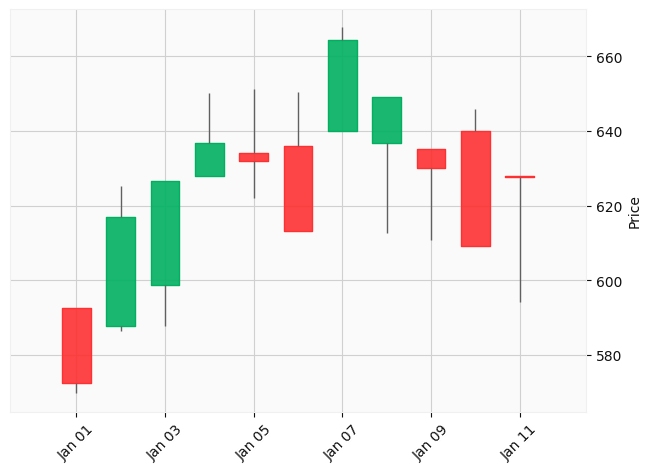

array(['Hanging Man'], dtype='<U17')

In [10]:
idx = 10
temp = next(iter(dataloader))
print_pattern(temp[0][idx].permute(0, 2, 1).squeeze())
dataset.label_encoder.inverse_transform(temp[1][idx].unsqueeze(0).numpy())

In [11]:
class Discriminator(nn.Module):
    def __init__(self, image_dim, ndf):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(image_dim, ndf),
            nn.LeakyReLU(0.01),
            nn.Linear(ndf, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

class Generator(nn.Module):
    def __init__(self, nz, image_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, image_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
nz = 100
image_dim = 4*11*1
ndf = 128
batch_size = 32
num_epochs = 100

discriminator = Discriminator(image_dim, ndf).to(device)
generator = Generator(nz, image_dim).to(device)
fixed_noise = torch.randn((batch_size, nz)).to(device)
optimizerD = optim.Adam(discriminator.parameters(), lr=lr)
optimizerG = optim.Adam(generator.parameters(), lr=lr)
criterion = nn.BCELoss()

In [13]:
for epoch in range(num_epochs):
    print(f"EPOCH: {epoch} \n--------")

    for i, (real, _) in enumerate(dataloader):
        real = real.view(-1, 44).to(device)
        batch_size = real.shape[0]

        #########################  
        # Discriminator
        #########################  

        noise = torch.rand(batch_size, nz).to(device)
        fake = generator(noise)
        
        disc_real = discriminator(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = discriminator(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        lossD = (lossD_real + lossD_fake) / 2

        real_preds = (disc_real > 0.5).float()
        fake_preds = (disc_fake < 0.5).float()
        disc_acc = torch.mean(torch.cat([real_preds, fake_preds])).item()

        discriminator.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()

        #########################  
        # Generator
        #########################  

        output = discriminator(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))

        gen_acc = torch.mean((output > 0.5).float()).item()
        
        generator.zero_grad()
        lossG.backward()
        optimizerG.step()
        
        if i == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}, \
                      Disc Acc: {disc_acc:.4f}, Gen Acc: {gen_acc:.4f}"
            )

        

EPOCH: 0 
--------
Epoch [0/100] Batch 0/155                       Loss D: 0.3441, loss G: 0.7019,                       Disc Acc: 0.8281, Gen Acc: 0.1250
EPOCH: 1 
--------
Epoch [1/100] Batch 0/155                       Loss D: 0.2220, loss G: 1.0698,                       Disc Acc: 1.0000, Gen Acc: 0.0000
EPOCH: 2 
--------
Epoch [2/100] Batch 0/155                       Loss D: 0.1638, loss G: 1.2897,                       Disc Acc: 1.0000, Gen Acc: 0.0000
EPOCH: 3 
--------
Epoch [3/100] Batch 0/155                       Loss D: 0.2002, loss G: 1.1193,                       Disc Acc: 1.0000, Gen Acc: 0.0000
EPOCH: 4 
--------
Epoch [4/100] Batch 0/155                       Loss D: 0.1324, loss G: 1.4657,                       Disc Acc: 1.0000, Gen Acc: 0.0000
EPOCH: 5 
--------
Epoch [5/100] Batch 0/155                       Loss D: 0.0997, loss G: 1.7151,                       Disc Acc: 1.0000, Gen Acc: 0.0000
EPOCH: 6 
--------
Epoch [6/100] Batch 0/155                       Los

In [14]:
noise = torch.rand(1, nz).to(device)
with torch.inference_mode():
    syn_data = generator(noise)

In [15]:
syn_data

tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000, -1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  0.9998,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000]])

In [16]:
syn_data.view(11, 4)

tensor([[ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000, -1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 0.9998,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000]])